# Create a surrogate model for the objective function for the three survey line example

<!-- Please leave the cell below as it is -->

[![Open In Colab](https://img.shields.io/badge/open%20in-Colab-b5e2fa?logo=googlecolab&style=flat-square&color=ffd670)](https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/examples/airborne_em/airborne_em_three_lines_transmitters.ipynb)

<!-- Again, please don't touch the markdown cell above. We'll generate badge 
     automatically from the above cell. -->

<!-- This cell describes things related to environment setup, so please add more text 
     if something special (not listed below) is needed to run this notebook -->

> If you are running this notebook locally, make sure you've followed [steps here](https://github.com/inlab-geo/cofi-examples#run-the-examples-with-cofi-locally)
to set up the environment. (This [environment.yml](https://github.com/inlab-geo/cofi-examples/blob/main/envs/environment.yml) file
specifies a list of packages required to run the notebooks)

In [1]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !pip install -U cofi
# !pip install git+https://github.com/JuergHauser/PyP223.git
# !pip install smt
# !git clone https://github.com/inlab-geo/cofi-examples.git
# %cd cofi-examples/examples/vtem_max

In [7]:
# If this notebook is run locally PyP223 and smt need to be installed separately by uncommenting the following lines, 
# that is by removing the # and the white space between it and the exclamation mark.
# !pip install git+https://github.com/JuergHauser/PyP223.git
# !pip install smt

  Cloning https://github.com/JuergHauser/PyP223.git to /tmp/pip-req-build-w_iy0mzu
  Running command git clone --filter=blob:none --quiet https://github.com/JuergHauser/PyP223.git /tmp/pip-req-build-w_iy0mzu
  Resolved https://github.com/JuergHauser/PyP223.git to commit 34bdae4f3e74165f03e53374b39f718a03e9f63b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pyp223: filename=pyp223-0.1.0-cp313-cp313-linux_x86_64.whl size=558253 sha256=b541201c85b74dddd86d391445b02cefdf521959dd06c05ca955454390395346
  Stored in directory: /tmp/pip-ephem-wheel-cache-q3lguurj/wheels/4e/a4/ff/3c8c552e3cea1b99f6491eba69622d3339918cd260970bf559
Successfully built pyp223

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [8]:
import pickle
import numpy
import matplotlib.pyplot as plt
import cofi
import smt
import smt.sampling_methods
import smt.surrogate_models 
import smt.utils.misc
import tqdm
from vtem_max_forward_lib import (
    problem_setup, 
    system_spec, 
    survey_setup, 
    ForwardWrapper
)

numpy.random.seed(42)
numpy.set_printoptions()

# Background

This example use the surrogate modelling toolbox to create a surrogate model for the objective function used in the synthetic [example](./three_survey_lines.ipynb) where we invert the vertical component of three survey lines of a VTEM max survey. This notebook employs the  [Kriging approach](https://smt.readthedocs.io/en/latest/_src_docs/surrogate_models/gpr/krg.html) using the training and test samples generated [here](three_survey_lines_latin_hypercube_sampling.ipynb) to create a surrogate model.


In [9]:
with open('three_survey_lines_lhs.npy', 'rb') as f:
    ndim=int(numpy.load(f))
    xlimits=numpy.load(f) 
    xtrain=numpy.load(f)
    ytrain=numpy.load(f)
    xtest=numpy.load(f)
    ytest=numpy.load(f)

xlimits=xlimits.astype('double')
xtrain=xtrain[0:150].astype('double')
ytrain=ytrain[0:150].astype('double')
xtest=xtest[0:25].astype('double')
ytest=ytest[0:25].astype('double')

## Training 

In [10]:
# The variable 'theta0' is a list of length ndim.
t = smt.surrogate_models.KRG(theta0=[1e-2]*ndim,print_prediction = False)
t.set_training_values(xtrain,ytrain)
t.train()

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 100
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  5.7195978


## Validation

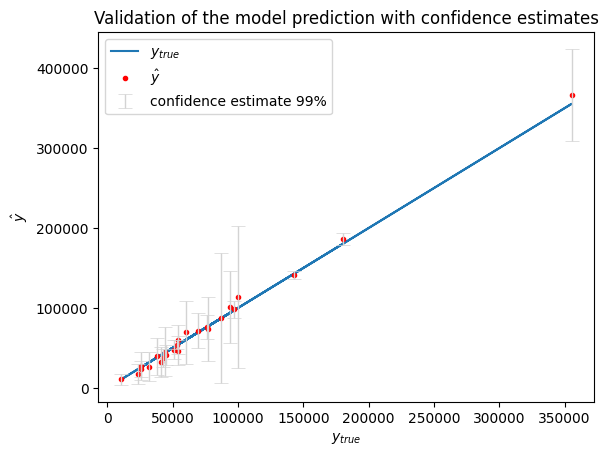

In [11]:
# Prediction of the validation points
y = t.predict_values(xtest)
# Estimated variance for the validation points
s2 = t.predict_variances(xtest)
#plot with the associated interval confidence
yerr= 2*3*numpy.sqrt(s2) #in order to use +/- 3 x standard deviation: 99% confidence interval estimation

# Plot the function, the prediction and the 99% confidence interval based on
# the MSE
fig = plt.figure()
plt.plot(ytest, ytest, '-', label='$y_{true}$')
plt.plot(ytest, y, 'r.', label='$\\hat{y}$')
plt.errorbar(numpy.squeeze(ytest), numpy.squeeze(y), yerr=numpy.squeeze(yerr), fmt = 'none', capsize = 5, ecolor = 'lightgray', elinewidth = 1, capthick = 0.5, label='confidence estimate 99%')
plt.xlabel('$y_{true}$')
plt.ylabel('$\\hat{y}$')

plt.legend(loc='upper left')
plt.title('Validation of the model prediction with confidence estimates')   
plt.show()

## Save the surrogate model for subsequent use

In [12]:
filename = "kriging_surrogate_model.pkl"
with open(filename, "wb") as f:
   pickle.dump(t, f)

---
# Watermark

<!-- Feel free to add more modules in the watermark_list below, if more packages are used -->
<!-- Otherwise please leave the below code cell unchanged -->

In [13]:
watermark_list = ["cofi", "numpy", "scipy", "matplotlib","smt"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

cofi 0.2.9
numpy 2.1.3
scipy 1.14.1
matplotlib 3.9.2
smt 2.8.0
